In [47]:
from pathlib import Path
import joblib
import optuna.visualization as vis

# 1. Setup Paths
results_path = Path().cwd().parent / "results"
pickle_file = results_path / "electricity_study.pkl"
plots_path = results_path / "plots"
plots_path.mkdir(parents=True, exist_ok=True)

# 2. Load the Study
if pickle_file.exists():
    study = joblib.load(pickle_file)
    print(f"✅ Study '{study.study_name}' loaded successfully.")
else:
    print("❌ Pickle file not found! Check your path.")

# 3. Generate Interactive Visuals (for the notebook)
# History shows convergence toward the best MAPE
fig_history = vis.plot_optimization_history(study)
fig_history.show()

# Importance identifies the 'heavy hitters' among your 10 models
fig_importance = vis.plot_param_importances(study)
fig_importance.show()

# 4. Export High-Res PNGs for your LaTeX Report
# Scale=2 ensures they are crisp on the printed page
fig_history.write_image(plots_path / "optimization_history.png", scale=2)
fig_importance.write_image(plots_path / "param_importance.png", scale=2)
fig_slice = vis.plot_slice(study)
fig_slice.write_image(plots_path / "slice_plot.png", scale=2)

print(f"🖼️ Plots exported to: {plots_path}")


✅ Study 'Electricity_Consumption_Tuning' loaded successfully.


🖼️ Plots exported to: /home/bhavik/Dropbox/edu/smu/winter/data_mining/a4_regression_ts/results/plots


Choise of model is more important than hyperparameter tuning for this problem. 

In [48]:
import pandas as pd

# 1. Get the raw data from your study
df_results = study.trials_dataframe()

# 2. Extract and clean the Model Type and Value (MAPE)
# We group by the model name and take the minimum MAPE found during the 100 trials
leaderboard = df_results.groupby('params_model_type')['value'].min().reset_index()
leaderboard.columns = ['Model Architecture', 'Best MAPE (%)']

# 3. Sort by performance (lowest error first)
leaderboard = leaderboard.sort_values(by='Best MAPE (%)')

# 4. Display the table
print("🏆 Electricity Study: Model Error Rates")
print(leaderboard.to_string(index=False))


🏆 Electricity Study: Model Error Rates
Model Architecture  Best MAPE (%)
             ARIMA       0.999922
        NN_3_Layer       1.162389
          LightGBM       1.170014
               SVR       1.176248
        NN_1_Layer       1.181466
           XGBoost       1.201468
    RegressionTree       1.259295
  LinearRegression       1.280555
       HoltWinters      14.754727


## Final Steps:
1. Retrain tuned models on train + validation set
2. Test models on test set
3. Choose best model based on MAPE results

In [49]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tensorflow as tf

# Define Paths
data_path = Path().cwd().parent / "data" / "electricity_data_split.pkl"
study_path = Path().cwd().parent / "results" / "electricity_study.pkl"
results_path = Path().cwd().parent / "results"

# Load Study and Data
study = joblib.load(study_path)
data = joblib.load(data_path)

# Combine Train + Val for the final retraining
X_train_full = np.vstack((data["X_train_scaled"], data["X_val_scaled"]))
y_train_full = np.concatenate((data["y_train_scaled"], data["y_val_scaled"]))
X_test = data["X_test_scaled"]
y_test = data["y_test_scaled"]

print(f"✅ Loaded {len(study.trials)} trials.")
print(f"📊 Training on {len(X_train_full)} samples. Testing on {len(X_test)} samples.")


✅ Loaded 100 trials.
📊 Training on 118492 samples. Testing on 20911 samples.


In [50]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set your path
results_path = Path().cwd().parent / "results"

# Load via Joblib (best for exact DF preservation)
df_results = joblib.load(results_path / "final_df_results.pkl")

# Or via CSV
# df_results = pd.read_csv(results_path / "final_test_results.csv", index_col=0)

print(df_results)


                       MAPE        RMSE         MAE       Time_ms
LinearRegression  11.489803   40.215916   28.935758     23.105090
HoltWinters       54.882937  208.093392  175.363585  45085.023784
ARIMA             63.364655  138.861493  119.589536  20780.084881
SVR               10.585287   38.283727   27.861223   7890.902046
RegressionTree    10.711633   40.462882   28.982416    536.433294
XGBoost           10.389348   38.068674   28.054745   1178.442357
LightGBM           9.880482   36.025911   26.570210  10513.369354
NN_1_Layer        10.668888   37.795014   27.867879  29785.050407
NN_3_Layer        10.762344   36.848806   27.468795  39885.910275


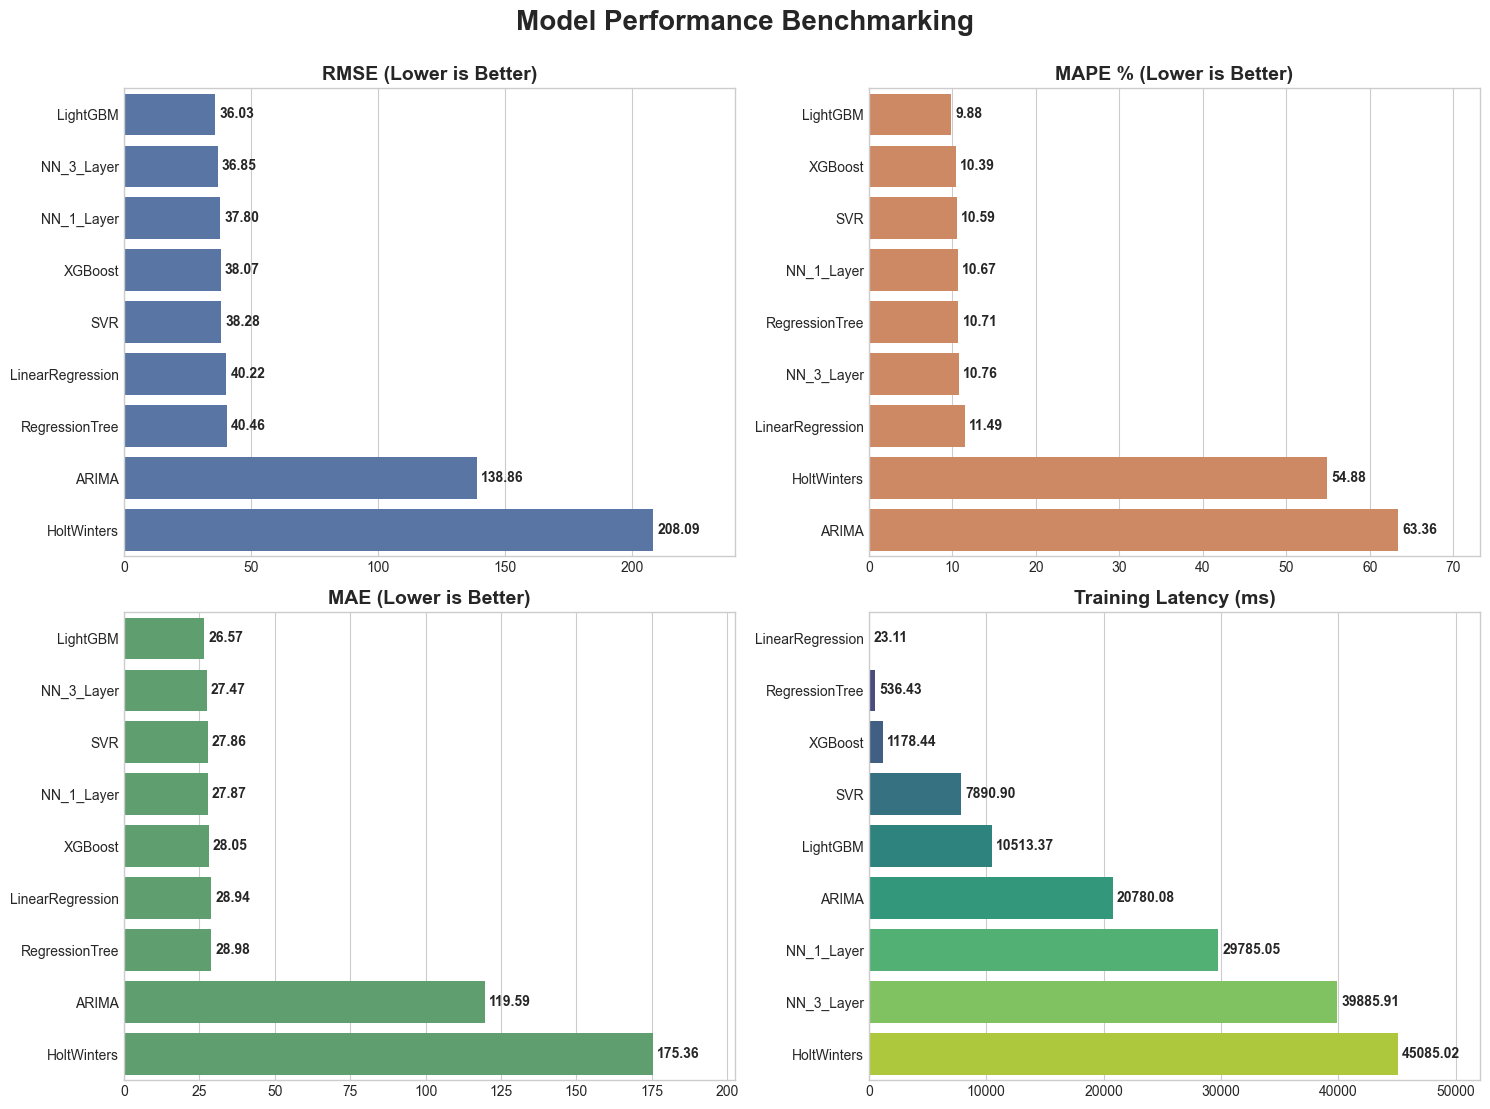

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sort based on your priority
df_sorted = df_results.sort_values(
    by=["RMSE", "MAPE", "MAE", "Time_ms"], 
    ascending=[True, True, True, True]
)

# 2. Setup the visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Benchmarking', fontsize=20, fontweight='bold', y=0.95)

metrics = ["RMSE", "MAPE", "MAE", "Time_ms"]
titles = ["RMSE (Lower is Better)", "MAPE % (Lower is Better)", 
          "MAE (Lower is Better)", "Training Latency (ms)"]
colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    
    # Sort for visual ranking
    plot_data = df_results.sort_values(metric)
    
    sns.barplot(
        x=metric, 
        y=plot_data.index, 
        data=plot_data, 
        ax=ax,
        color=colors[i] if "Time" not in metric else None,
        palette="viridis" if "Time" in metric else None,
        hue=plot_data.index if "Time" in metric else None,
        legend=False
    )
    
    # --- ADDING NUMBERS ON BARS ---
    # We iterate through the containers (the bars) and add labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')
    
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Add some extra room on the x-axis so labels don't get cut off
    ax.set_xlim(right=ax.get_xlim()[1] * 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(results_path / "model_benchmarks_with_labels.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [52]:
df_results.info()


<class 'pandas.DataFrame'>
Index: 9 entries, LinearRegression to NN_3_Layer
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MAPE     9 non-null      float64
 1   RMSE     9 non-null      float64
 2   MAE      9 non-null      float64
 3   Time_ms  9 non-null      float64
dtypes: float64(4)
memory usage: 360.0+ bytes


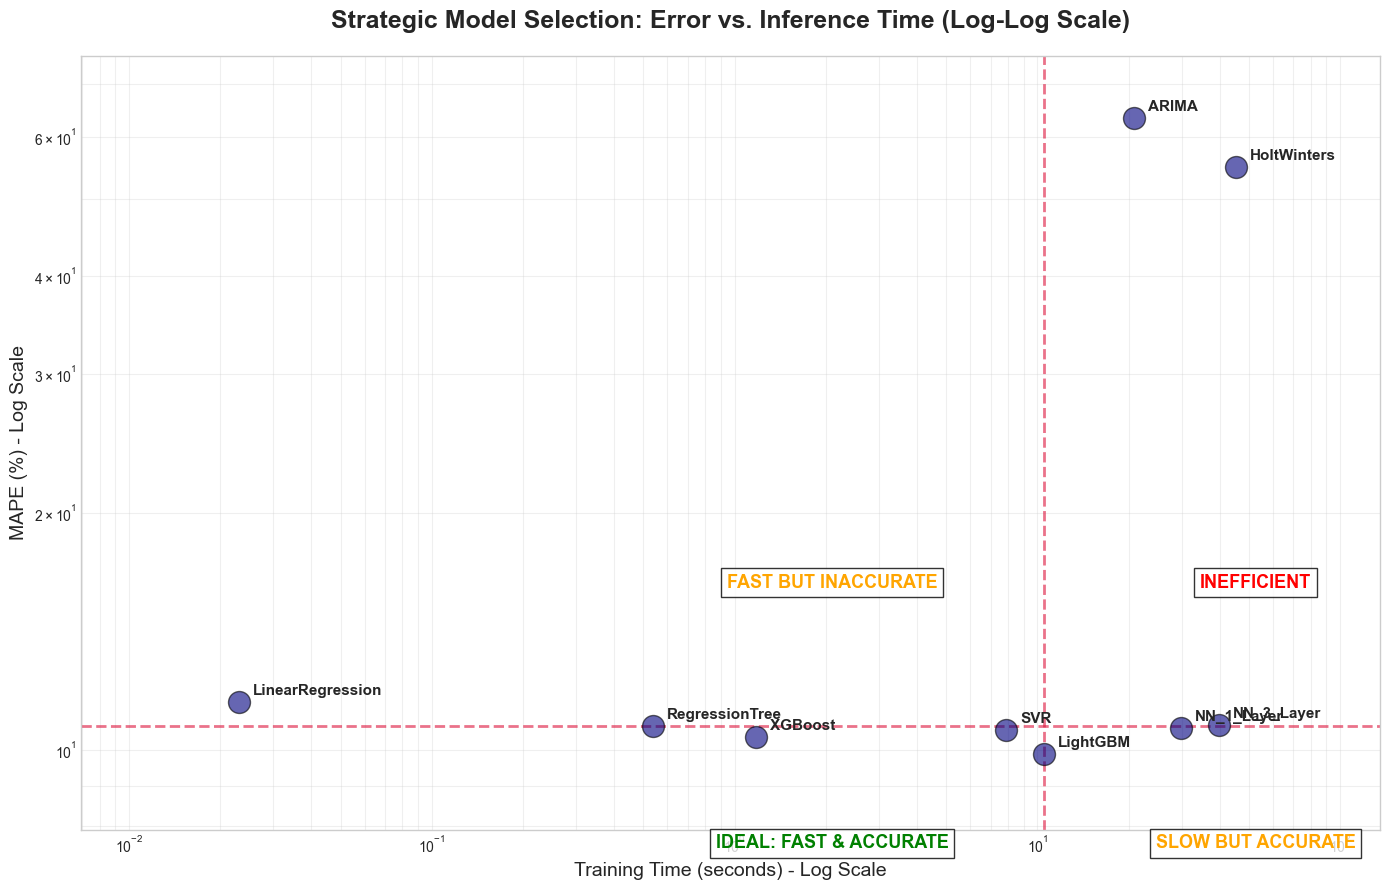

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare data
df_plot = df_results.reset_index().rename(columns={'index': 'Model'})
df_plot['Time_s'] = df_plot['Time_ms'] / 1000

# 2. Define Thresholds
time_threshold = df_plot['Time_s'].median()
mape_threshold = df_plot['MAPE'].median()

# 3. Create the Visualization
plt.figure(figsize=(14, 9))
plt.style.use('seaborn-v0_8-whitegrid')

# Main Scatter Plot
plt.scatter(df_plot['Time_s'], df_plot['MAPE'], s=250, c='navy', alpha=0.6, edgecolors='black', zorder=3)

# Annotate Model Names with slight offsets to prevent overlap
for i, row in df_plot.iterrows():
    plt.annotate(row['Model'], (row['Time_s'], row['MAPE']), 
                 xytext=(10, 5), textcoords='offset points', fontsize=11, fontweight='bold')

# Draw Quadrant Dividers
plt.axvline(x=time_threshold, color='crimson', linestyle='--', linewidth=2, alpha=0.6)
plt.axhline(y=mape_threshold, color='crimson', linestyle='--', linewidth=2, alpha=0.6)

# Label the Quadrants
# Adjusted positioning for Dual-Log Scale
plt.text(time_threshold * 0.2, mape_threshold * 0.7, 'IDEAL: FAST & ACCURATE', 
         color='green', fontsize=13, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.text(time_threshold * 5, mape_threshold * 0.7, 'SLOW BUT ACCURATE', 
         color='orange', fontsize=13, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.text(time_threshold * 0.2, mape_threshold * 1.5, 'FAST BUT INACCURATE', 
         color='orange', fontsize=13, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.text(time_threshold * 5, mape_threshold * 1.5, 'INEFFICIENT', 
         color='red', fontsize=13, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))

# Final Formatting
plt.xscale('log') 
plt.yscale('log') # Adding Log Scale to MAPE
plt.title('Strategic Model Selection: Error vs. Inference Time (Log-Log Scale)', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('Training Time (seconds) - Log Scale', fontsize=14)
plt.ylabel('MAPE (%) - Log Scale', fontsize=14)

# Set grid for both scales
plt.grid(True, which="both", ls="-", alpha=0.3)

# Adjust limits to ensure labels fit
plt.xlim(df_plot['Time_s'].min() * 0.3, df_plot['Time_s'].max() * 3)
plt.ylim(df_plot['MAPE'].min() * 0.8, df_plot['MAPE'].max() * 1.2)

plt.tight_layout()
plt.savefig(results_path / 'quadrant_log_log.png', dpi=300)
plt.show()
